# Popular Board Games

Board games have seen increasing popularity in recent years after an initial decline that occurred with the advent and growth of computer games.  Popularity is strong enough that there is entire website known as BoardGameGeek that is dedicated to discussing and reviewing board games.  The data from BoardGameGeek that is used in this analysis was scraped and compiled into CSV format by Sean Beck ( https://github.com/ThaWeatherman/scrapers/blob/master/boardgamegeek/games.csv).  The data contains the number of players, the average playing time it takes to complete one round of the board game, number of users ratings, and average ratings.  The main purpose of this code is to examine ratings of popular board games and the characteristics that leads to higher popularity.  This analysis can help in identifying the key ingredients that should be considered in designing a successful board game. It uses clustering techniques initially before running a linear regression.

In [3]:
import pandas as pd

#read-in dataframe and drop rows that contain missing values and have no reviews
board_games = pd.read_csv("board_games.csv")
print(board_games.head(10))
print(board_games.shape)
board_games = board_games.dropna()
print(board_games.shape)
board_games = board_games[board_games["average_rating"] != 0]
print(board_games.shape)

       id       type                                       name  \
0   12333  boardgame                          Twilight Struggle   
1  120677  boardgame                              Terra Mystica   
2  102794  boardgame                  Caverna: The Cave Farmers   
3   25613  boardgame  Through the Ages: A Story of Civilization   
4    3076  boardgame                                Puerto Rico   
5   31260  boardgame                                   Agricola   
6  124742  boardgame                         Android: Netrunner   
7   96848  boardgame                     Mage Knight Board Game   
8   84876  boardgame                    The Castles of Burgundy   
9   72125  boardgame                                    Eclipse   

   yearpublished  minplayers  maxplayers  playingtime  minplaytime  \
0         2005.0         2.0         2.0        180.0        180.0   
1         2012.0         2.0         5.0        150.0         60.0   
2         2013.0         1.0         7.0        210.

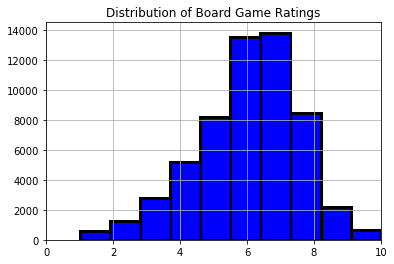

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

board_games["average_rating"].hist(edgecolor='black',lw=3, color= 'b')
plt.title("Distribution of Board Game Ratings")
plt.xlim(0,10.0)
plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x7f883ef75e48>],
 'caps': [<matplotlib.lines.Line2D at 0x7f883ef7d7f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f883ef7ff98>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f883ef7f160>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f883ef75fd0>,
  <matplotlib.lines.Line2D at 0x7f883ef7af98>]}

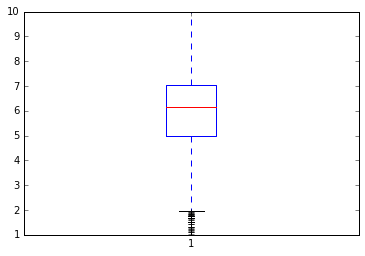

In [9]:
plt.boxplot(board_games["average_rating"])

In [14]:
print("Mean rating: {}".format(round(board_games["average_rating"].mean(),2)))
print("Standard deviation of rating: {}".format(round(board_games["average_rating"].std(),2)))

Mean rating: 6.02
Standard deviation of rating: 1.58


### Average Ratings of Board Games

Average ratings are above the mid-point of 5 with a mean of 6.016 and a standard deviation of 1.58.  This suggests that 66% of the sample falls within a rating between 4.5 and 7.5.  The distribution below the mean is more spread out indicating that the median value would be lower.  In general, the shape looks like it somewhat follows a normal distribution.

A good error metric is potentially the mean squared error since average ratings can be considered continuous values (between 0-10).  Below we use clustering to examine how different characteristics of board games are related.

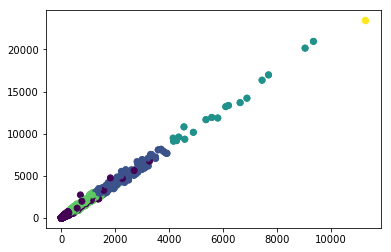

In [18]:
from sklearn.cluster import KMeans
import numpy as np

#Create 5 clusters over numeric columns
kmeans_model = KMeans(n_clusters=5, random_state=1)
numeric_columns = board_games.iloc[:,4:]
distances = kmeans_model.fit(numeric_columns)
labels = kmeans_model.labels_

#Plot the mean and standard deviations of distances
#Patterns can help identify a machine learning model
game_mean = numeric_columns.apply(np.mean,axis=1)
game_std = numeric_columns.apply(np.std,axis=1)
plt.scatter(game_mean,game_std,c=labels)
plt.show()



#### Interpreting the clusters

The scatter plot indicates that there is a lot of overlap between 4 of the clusters.
This may indicate that the distances of most games are not that far from one another.  The scatter plot also indicates that as the game attributes increase in value due to user ratings, complexity etc, there are fewer games. This indicates that many games are not ranked that high and also do not get played as much resulting in lower variation.  This can be derived from observing that total_owners column is the main item driving the clustering values observed in the graph.

In [20]:
correlations = numeric_columns.corr()
print(correlations["average_rating"])

minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64


#### Correlations of board game characteristics with average ratings

Most of the correlations between board game characteristics and average ratings are low indicating that things such as playing time of the board game, age of te board game etc. do not play a huge role in the popularity of a board game.  However, average_weight indicating a game is more complex or difficult is highly correlated with the board game ratings.  OThe average bayes rating (derived from average rating) and the minumum age also have higher correlations with the average rating.

In [24]:
#drop columns that are derived from average rating
numeric_columns1 = numeric_columns.drop(["bayes_average_rating"],1)
print(numeric_columns1.shape)
#drop columns that are not correlated with average rating
numeric_columns1 = numeric_columns.drop(["minplayers","maxplayers","playingtime","minplaytime","maxplaytime"],1)
print(numeric_columns1.shape)

(56894, 15)
(56894, 11)


In [41]:
#use statsmodel to actually analyzes the significance of various variables in determining the rating
import statsmodels.api as sm
import numpy as np
numeric_columns1["intercept"] = 1.0
xcols = ["minage","total_owners","total_wanters","total_traders", "total_wishers","average_weight"]
ols = sm.OLS(numeric_columns1["average_rating"],numeric_columns1[xcols])
result = ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                 3.104e+04
Date:                Mon, 08 May 2017   Prob (F-statistic):               0.00
Time:                        21:13:22   Log-Likelihood:            -1.4340e+05
No. Observations:               56894   AIC:                         2.868e+05
Df Residuals:                   56888   BIC:                         2.869e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
minage             0.4218      0.002    212.

In [42]:
#undertake a linear regression model

from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg.fit(numeric_columns1[["total_owners","total_wanters","total_wishers","average_weight"]],numeric_columns1["average_rating"])
prediction = reg.predict(numeric_columns1[["total_owners","total_wanters","total_wishers","average_weight"]])
print(prediction[0:5])
print(numeric_columns["average_rating"][0:5])

#calculate error metric of mean squared error
MSE = sum(prediction-numeric_columns1["average_rating"])/len(prediction)
print(MSE)


[  8.80418294  10.32394748  10.18839123   8.62509101   7.80811976]
0    8.33774
1    8.28798
2    8.28994
3    8.20407
4    8.14261
Name: average_rating, dtype: float64
5.47809416207e-15


### Interpretation of results

The error metric of root mean squared error is extremely close to 0.  This means that the prediction is quite close to actual values and the model fit is quite good.  However, the linear regression results actually indicate that the r^2 is high.  However the right hand side variables are all statistically predictors of ratings.  Nevertheless the only meaningful design item that is included in the regression is board game complexity and minimum age (which are probably related) given that board games rated for older age groups are typically more complex.

#### Extending the analysis

Here we examine if additional variable scould be created and examine problems of multicollinearity.  Below we see that constructing additional variables based on average players, average playing time, share of users rating are not strong determinants of average ratings.  Moreover, the correlations between owner, traders, wanters, and total wishers are highly correlated suggesting that we either focus only on including one of these four indicators in the model or we create index that synthesizes the four into one.

# Potential next steps....

That's it for the guided steps. We recommend downloading this notebook and building on it. Here are some potential next steps:

Split the data into training and testing sets, and calculate error on the testing set.
Try algorithms other than linear regression.
Calculate new predictors based off the existing columns, such as:
Player range (maxplayers - minplayers)
Playing time range (maxplaytime - minplaytime)
Average number of ratings (total_owners / users_rated)
Scrape the latest data from BoardGameGeek to acquire more data.

In [43]:
numeric_columns["avg_player"]=(numeric_columns["maxplayers"]+numeric_columns["minplayers"])/2
numeric_columns["avg_playtime"]=(numeric_columns["maxplaytime"]-numeric_columns["minplaytime"])/2
numeric_columns["share_owners_rating"]=numeric_columns["users_rated"]/numeric_columns["total_owners"]
correlations = numeric_columns.corr()
print(correlations["average_rating"])
new_correlations = numeric_columns[["total_owners","total_traders","total_wanters","total_wishers"]].corr()
print(new_correlations)

minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
avg_player             -0.008839
avg_playtime            0.025640
share_owners_rating    -0.088467
total_engagement        0.148763
Name: average_rating, dtype: float64
               total_owners  total_traders  total_wanters  total_wishers
total_owners       1.000000       0.829875       0.688380       0.788820
total_traders      0.829875       1.000000       0.555836       0.631443
total_wanters      0.688380       0.555836       1.000000       0.961002
total_wishe

In [44]:
# new index.  For ease, let's just sum the four columns together.  However, this index does not seem better
# so let's just select and use going forward the highest correlated of these (total_wanters)
numeric_columns["total_engagement"]=numeric_columns["total_owners"] + numeric_columns["total_traders"] + numeric_columns["total_wanters"] + numeric_columns["total_wishers"]
correlations = numeric_columns.corr()
print(correlations["average_rating"])

minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
avg_player             -0.008839
avg_playtime            0.025640
share_owners_rating    -0.088467
total_engagement        0.148763
Name: average_rating, dtype: float64


In [46]:
import statsmodels.api as sm
import numpy as np
numeric_columns1["intercept"] = 1.0
xcols = ["minage","total_wanters","average_weight"]
ols = sm.OLS(numeric_columns1["average_rating"],numeric_columns1[xcols])
result = ols.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         average_rating   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                 6.192e+04
Date:                Mon, 08 May 2017   Prob (F-statistic):               0.00
Time:                        21:13:50   Log-Likelihood:            -1.4346e+05
No. Observations:               56894   AIC:                         2.869e+05
Df Residuals:                   56891   BIC:                         2.869e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
minage             0.4208      0.002    212.

### Conclusions

The basic linear regression analysis revealed that ratings are strong determinant of only a few key variables.  Additional analysis may look into seeing how well the selected model works on a test set of data.  Scraping the data further may also be useful to obtain data on the publisher and classification information which provides details on categories the board game fits into and mechanisms of play.  This could all be useful in helping answer the question:  What characteristics of a board game matter in determining high user ratings?